#Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#Data

In [28]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','class','difficulty_level']

In [29]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain+.txt", names = features)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest+.txt", names = features)

print(train_df.shape)
print(test_df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(125967, 43)
(22549, 43)


In [30]:
#combining train and test files (there's an error when doing the one hot encoding)
data = pd.concat([train_df, test_df])
print(data.shape)
data.head()

(148516, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [31]:
data.info()
""" 
  'protocol_type','srevice', 'flag' : categorical types
  'difficulty_level'                : usless
  'class'                           : has multiplie classes of attaks and a normal class
  
  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148516 entries, 0 to 22548
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148516 non-null  int64  
 1   protocol_type                148516 non-null  object 
 2   service                      148516 non-null  object 
 3   flag                         148516 non-null  object 
 4   src_bytes                    148516 non-null  int64  
 5   dst_bytes                    148516 non-null  int64  
 6   land                         148516 non-null  int64  
 7   wrong_fragment               148516 non-null  int64  
 8   urgent                       148516 non-null  int64  
 9   hot                          148516 non-null  int64  
 10  num_failed_logins            148516 non-null  int64  
 11  logged_in                    148516 non-null  int64  
 12  num_compromised              148516 non-null  int64  
 13  

" \n  'protocol_type','srevice', 'flag' : categorical types\n  'difficulty_level'                : usless\n  'class'                           : has multiplie classes of attaks and a normal class\n  \n  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing\n"

In [32]:
#some stats
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,276.781168,40228.220165,17088.968657,0.000215,0.020523,0.000202,0.189380,0.004323,0.402792,0.255063,0.001508,0.000976,0.273728,0.012073,0.000525,0.004013,0.000000,0.000081,0.012308,83.333695,28.252121,0.256926,0.255339,0.137942,0.138481,0.672987,0.067755,0.097442,183.927563,119.463458,0.534524,0.084097,0.145933,0.030584,0.256123,0.251306,0.136215,0.136391,19.278495
std,2460.691310,5409629.816013,3703537.248657,0.014677,0.240070,0.019417,2.013167,0.072248,0.490461,22.231450,0.038807,0.042389,22.689100,0.517865,0.027701,0.095257,0.000000,0.008989,0.110259,116.755909,75.369855,0.431919,0.432579,0.339382,0.341777,0.436542,0.194651,0.258886,98.528487,111.232267,0.448061,0.194088,0.308638,0.108975,0.428501,0.429720,0.322736,0.335276,2.739760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,278.000000,571.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000,21.000000
max,57715.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,100.000000,5.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [33]:
#fixing labels
data.loc[data['class']!='normal','class']= 'attack'

##Data visualisation

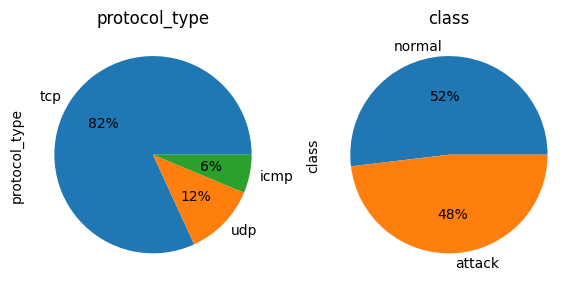

In [34]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(7, 7), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(data, ['protocol_type', 'class'], 1, 2)

# prétraitement



#### 1-Normalisation (Robuste)

In [35]:
#les colonnes doivent etre numeriques seulement
def normalisation(dataframe, columns):
  normalised_df = pd.DataFrame(RobustScaler().fit_transform(dataframe), columns = columns)
  return normalised_df
  

In [36]:
categorical_columns = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'difficulty_level', 'class']

In [37]:

def preprocessing(dataframe):
  #selectionner le valeurs numeriques puis les normaliser
  num_df = dataframe.drop(categorical_columns, axis=1)
  num_cols = num_df.columns
  normalized_df = normalisation(num_df, num_cols)


  #supression des ancienne données numeriques et rajout des données normalisées
  dataframe.drop(labels = num_cols, axis= 'columns', inplace = True)
  dataframe[num_cols] = normalized_df[num_cols]

  #remplaces les lables de la colonne 'class": 
  #0 => normal
  #1 => attak
  dataframe.loc[dataframe['class'] == "normal", "class"]= 0
  dataframe.loc[dataframe['class'] != 0, "class"] = 1 

  #onehot encoding
  dataframe = pd.get_dummies(dataframe, columns = ['protocol_type','service', 'flag'])

  return dataframe

In [38]:
normalized_df = preprocessing(data)
normalized_df

,land,logged_in,is_host_login,is_guest_login,class,difficulty_level,duration,src_bytes,dst_bytes,wrong_fragment,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,20,0.0,1.607914,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,15,0.0,0.366906,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,19,0.0,-0.158273,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,21,0.0,0.676259,14.278459,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,21,0.0,0.557554,0.735552,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22544,0,0,0,0,0,20,0.0,1.003597,1.052539,0.0,...,0,0,0,0,0,0,0,0,1,0
22545,0,0,0,0,0,21,0.0,1.057554,0.686515,0.0,...,0,0,0,0,0,0,0,0,1,0
22546,0,0,0,0,1,17,0.0,-0.158273,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
22547,0,0,0,0,1,17,0.0,0.870504,1.602452,0.0,...,1,0,0,0,0,0,0,0,0,0


##### Feature selection (reduction) PCA

In [39]:
#Extraction des X et Ys
x = normalized_df.drop(['class', 'difficulty_level'], axis = 1).values
y = normalized_df['class'].values.astype('int')
y_reg = normalized_df['difficulty_level'].values

#initialisation PCA
pca = PCA(n_components = 21)
pca = pca.fit(x)
x_r = pca.transform(x)

print("# Of original features: ", x.shape[1])
print("# Features after reduction: ", x_r.shape[1])

#Training splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

xr_train, xr_test, yr_train, yr_test = train_test_split(x_r, y, test_size = 0.3, random_state = 42)

xreg_train, xreg_test, yreg_train, yreg_test = train_test_split(x, y_reg, test_size = 0.3 , random_state = 42)


# Of original features:  121
# Features after reduction:  21


In [40]:
evaluations = dict()

def evaluate(model, model_name, x_train, x_test, y_train, y_test):
  #accuracy
  train_acc = metrics.accuracy_score(y_train, model.predict(x_train))
  test_acc = metrics.accuracy_score(y_test, model.predict(x_test))

  #recall
  train_rec = metrics.recall_score(y_train, model.predict(x_train))
  test_rec = metrics.recall_score(y_test, model.predict(x_test))

  #precision
  train_pre = metrics.precision_score(y_train, model.predict(x_train))
  test_pre = metrics.precision_score(y_test, model.predict(x_test))

  #F1-score
  train_f1 = metrics.f1_score(y_train, model.predict(x_train))
  test_f1 = metrics.f1_score(y_test, model.predict(x_test))

  #save into evalutations and printing
  evaluations[str(model_name)] = [train_acc, test_acc, train_pre, test_pre, train_rec, test_rec, train_f1, test_f1]
  print(str(model_name)+" Results :")
  print("Training Accuracy  {}  Test Accuracy ".format(train_acc*100) +  " {}".format(test_acc*100))
  print("Training Precision  {}  Test Precision ".format(train_pre*100) + " {}".format(test_pre*100))
  print("Training Recall  {}  Test Recall ".format(train_rec*100) + " {}".format(test_rec*100))
  print("Training F1 Score  {}  Test F1 Score ".format(train_f1*100) + " {}".format(test_f1*100))
  
  #confusion matrix
  predicted = model.predict(x_test)
  cm = metrics.confusion_matrix(y_test, predicted)
  cm_display = metrics.ConfusionMatrixDisplay(cm,display_labels = ['Normal', 'Attack'])
  fig, ax = plt.subplots(figsize = (5,5))
  ax.grid(False)
  cm_display.plot(ax=ax)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results :
Training Accuracy  82.02499014053348  Test Accuracy  82.18381775333857
Training Precision  84.18569955461945  Test Precision  84.68445616883116
Training Recall  76.97291875626881  Test Recall  77.2394965759763
Training F1 Score  80.41790231480995  Test F1 Score  80.79082373439164


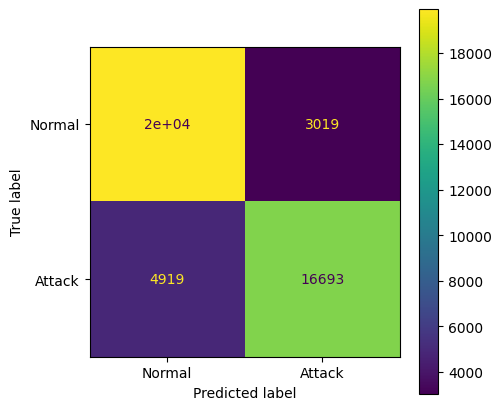

In [41]:
lr = LogisticRegression().fit(x_train, y_train)
evaluate(lr, "Logistic Regression", x_train, x_test, y_train, y_test)

In [42]:
"""
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)
evaluate(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)
"""

'\nfrom sklearn.neighbors import KNeighborsClassifier\nknn = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)\nevaluate(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)\n'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression on pca Results :
Training Accuracy  85.38971345023614  Test Accuracy  85.23622489058467
Training Precision  87.24826444859973  Test Precision  87.20182124121548
Training Recall  81.43229689067202  Test Recall  81.52878030723673
Training F1 Score  84.24001577139774  Test F1 Score  84.26993160839831


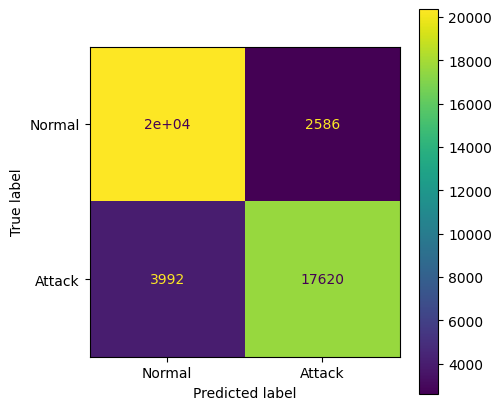

In [43]:
lr2 = LogisticRegression().fit(xr_train, yr_train)
evaluate(lr2, "Logistic Regression on pca", xr_train, xr_test, yr_train, yr_test)

In [45]:
import tensorflow as tf
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(accuracy*100))


Epoch 1/10
3249/3249 [==============================] - 17s 5ms/step - loss: 5.0232 - accuracy: 0.9336 - val_loss: 5.4975 - val_accuracy: 0.9485
Epoch 2/10
3249/3249 [==============================] - 15s 5ms/step - loss: 3.3848 - accuracy: 0.9550 - val_loss: 2.5918 - val_accuracy: 0.9609
Epoch 3/10
3249/3249 [==============================] - 15s 5ms/step - loss: 8.1875 - accuracy: 0.9588 - val_loss: 6.3951 - val_accuracy: 0.9609
Epoch 4/10
3249/3249 [==============================] - 15s 5ms/step - loss: 4.5745 - accuracy: 0.9625 - val_loss: 3.8269 - val_accuracy: 0.9700
Epoch 5/10
3249/3249 [==============================] - 17s 5ms/step - loss: 1.9144 - accuracy: 0.9624 - val_loss: 1.9797 - val_accuracy: 0.9646
Epoch 6/10
3249/3249 [==============================] - 17s 5ms/step - loss: 2.2119 - accuracy: 0.9643 - val_loss: 11.0104 - val_accuracy: 0.9697
Epoch 7/10
3249/3249 [==============================] - 14s 4ms/step - loss: 10.1483 - accuracy: 0.9645 - val_loss: 5.1918 - val_

In [46]:
import tensorflow as tf
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(xr_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(xr_train, yr_train, epochs=10, batch_size=32, validation_data=(xr_test, yr_test))

# Evaluate the model
loss, accuracy = model.evaluate(xr_test, yr_test)
print("Test accuracy: {:.2f}%".format(accuracy*100))


Epoch 1/10
3249/3249 [==============================] - 15s 4ms/step - loss: 8.1719 - accuracy: 0.7382 - val_loss: 4.3170 - val_accuracy: 0.9288
Epoch 2/10
3249/3249 [==============================] - 14s 4ms/step - loss: 3.3810 - accuracy: 0.9080 - val_loss: 14.2964 - val_accuracy: 0.9322
Epoch 3/10
3249/3249 [==============================] - 14s 4ms/step - loss: 0.2679 - accuracy: 0.9197 - val_loss: 0.1627 - val_accuracy: 0.9395
Epoch 4/10
3249/3249 [==============================] - 14s 4ms/step - loss: 0.1884 - accuracy: 0.9294 - val_loss: 0.1543 - val_accuracy: 0.9385
Epoch 5/10
3249/3249 [==============================] - 14s 4ms/step - loss: 0.1772 - accuracy: 0.9344 - val_loss: 0.1428 - val_accuracy: 0.9448
Epoch 6/10
3249/3249 [==============================] - 14s 4ms/step - loss: 0.1606 - accuracy: 0.9404 - val_loss: 0.1407 - val_accuracy: 0.9420
Epoch 7/10
3249/3249 [==============================] - 14s 4ms/step - loss: 0.1585 - accuracy: 0.9424 - val_loss: 0.1326 - val_a

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy.random import seed

from keras.models import Sequential
from keras.layers import Dense, Dropout


def test_dl_models(X_train, X_test, y_train, y_test):
    # Split the data into training and testing sets
     
    
    # Define a list of layer sizes to try
    layer_sizes = [4, 5, 6, 7, 8, 9, 10]
    
    # Define a list to store the models and their accuracies
    models = []
    accuracies = []
    
    # Loop over the layer sizes and train a model for each
    for layer_size in layer_sizes:
        # Create a new model
        model = Sequential()
        
        # Add the input layer
        model.add(Dense(layer_size, activation='relu', input_dim=X_train.shape[1]))
        
        # Add additional hidden layers with dropout regularization
        for i in range(layer_size - 1):
            model.add(Dense(layer_size - i - 1, activation='relu'))
            model.add(Dropout(0.2))
        
        # Add the output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        
        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
        accuracy = metrics.accuracy_score(y_test, y_pred)
        
        # Save the model and its accuracy
        models.append(model)
        accuracies.append(accuracy)
    
    # Find the index of the model with the highest accuracy
    best_index = accuracies.index(max(accuracies))
    
    # Print the architecture of the best model
    best_model = models[best_index]
    print(best_model.summary())
    
    return best_model


best_model = test_dl_models(x_train, x_test, y_train, y_test)

1393/1393 [==============================] - 3s 2ms/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 8)                 976       
                                                                 
 dense_90 (Dense)            (None, 7)                 63        
                                                                 
 dropout_32 (Dropout)        (None, 7)                 0         
                                                                 
 dense_91 (Dense)            (None, 6)                 48        
                                                                 
 dropout_33 (Dropout)        (None, 6)                 0         
                                                                 
 dense_92 (Dense)            (None, 5)                 35        
                                                              

In [48]:
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/10
3249/3249 [==============================] - 21s 6ms/step - loss: 0.4029 - accuracy: 0.8281 - val_loss: 0.2102 - val_accuracy: 0.9632
Epoch 2/10
3249/3249 [==============================] - 22s 7ms/step - loss: 0.4060 - accuracy: 0.8273 - val_loss: 0.2148 - val_accuracy: 0.9570
Epoch 3/10
3249/3249 [==============================] - 22s 7ms/step - loss: 0.4131 - accuracy: 0.8275 - val_loss: 0.2178 - val_accuracy: 0.9569
Epoch 4/10
3249/3249 [==============================] - 23s 7ms/step - loss: 0.4083 - accuracy: 0.8276 - val_loss: 0.2118 - val_accuracy: 0.9639
Epoch 5/10
3249/3249 [==============================] - 23s 7ms/step - loss: 0.3995 - accuracy: 0.8296 - val_loss: 0.2099 - val_accuracy: 0.9645
Epoch 6/10
3249/3249 [==============================] - 22s 7ms/step - loss: 0.3991 - accuracy: 0.8303 - val_loss: 0.2052 - val_accuracy: 0.9646
Epoch 7/10
3249/3249 [==============================] - 23s 7ms/step - loss: 0.4033 - accuracy: 0.8304 - val_loss: 0.2080 - val_ac